In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_households,population_per_househoulds,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   longitude                   17564 non-null  float32 
 1   latitude                    17564 non-null  float32 
 2   housing_median_age          17564 non-null  int8    
 3   total_rooms                 17564 non-null  int16   
 4   total_bedrooms              17564 non-null  int16   
 5   population                  17564 non-null  int16   
 6   households                  17564 non-null  int16   
 7   median_income               17564 non-null  float32 
 8   median_house_value          17564 non-null  int32   
 9   ocean_proximity             17564 non-null  category
 10  median_income_cat           17564 non-null  int64   
 11  rooms_per_households        17564 non-null  float32 
 12  population_per_househoulds  17564 non-null  float32 
 13  bedrooms_per_roo

In [5]:
#Target
coluna_target = ['median_house_value'] 

#categorias que não tem ordem
coluna_one_hot_encoder = ['ocean_proximity']

#categorias que tem ordem
coluna_ordinal_encoder = ['median_income_cat'] 



In [6]:
#colunas robust scaler
colunas_robust_scaler = df.columns.difference(coluna_one_hot_encoder + coluna_ordinal_encoder + coluna_target)


In [7]:
#criando meu preprocessamento de colunas e features polinomiais

#Criando um pipeline para minhas colunas numericas
pipeline_robust = Pipeline(steps=[
    ('robust_scaler', RobustScaler()), #Primeiro aplico o robust scaler
    ('poly', PolynomialFeatures(degree=1, include_bias=False)) #Em cima desse resultado aplico o Polynomial features
])

#Aplicando o resultado do pipeline anterior scaler a todas as colunas numericas e preprocessamento categórcas
preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder), #O auto auto reconhece as categorias
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler) #Parecido com o standard, mas menos sensivel a outliers(bom de usar quando minha base tem muitos outliers)
    ],
)



In [8]:
#Separando meu target das features

#Features
X = df.drop(columns=coluna_target)

#Target
y = df[coluna_target]

In [9]:
#Verificando se meu modelo fica melhor com qual grau de polinomios


param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,2,3],
    'regressor__reg__alpha': [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
}

In [10]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid = param_grid   
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [13]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('robust_scaler_poly',
                                                                                       Pipeline(steps=[('robust_scaler',
                                                                                                        RobustScaler()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population',
       'population_per_househoulds', 'rooms_per_households', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])),
                                                     ('reg',
                                                      Ridge(alpha=10.0))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [28]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.014022
robust_scaler_poly__latitude,-0.959172
one_hot_encoder__ocean_proximity_INLAND,-0.468910
robust_scaler_poly__latitude longitude population_per_househoulds,-0.425457
robust_scaler_poly__population_per_househoulds,-0.331277
...,...
robust_scaler_poly__latitude^2 longitude,0.242762
robust_scaler_poly__latitude median_income population_per_househoulds,0.242945
robust_scaler_poly__housing_median_age median_income,0.253403
robust_scaler_poly__bedrooms_per_room,0.344188


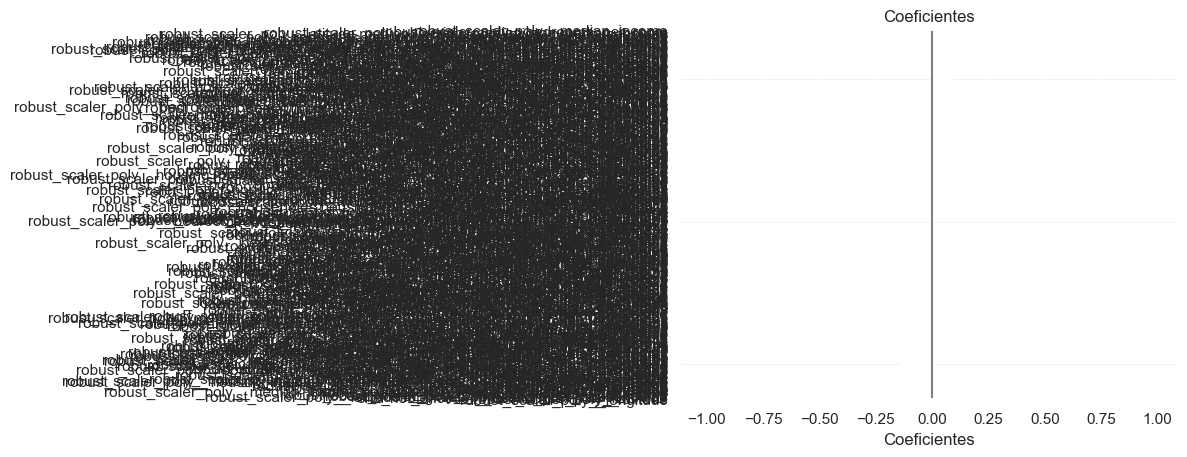

In [30]:
plot_coeficientes(coefs)

In [36]:
#Verificando coeficientes que estão dentro de faixas insignificantes

coefs[coefs['coeficiente'].between(-0.2, 0.2)]

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.198748
robust_scaler_poly__housing_median_age population_per_househoulds total_bedrooms,-0.197044
robust_scaler_poly__housing_median_age median_income population_per_househoulds,-0.182117
robust_scaler_poly__bedrooms_per_room rooms_per_households,-0.181161
robust_scaler_poly__longitude population_per_househoulds total_bedrooms,-0.175711
...,...
robust_scaler_poly__housing_median_age latitude rooms_per_households,0.173217
robust_scaler_poly__median_income population population_per_househoulds,0.176981
robust_scaler_poly__median_income population rooms_per_households,0.178800
robust_scaler_poly__bedrooms_per_room longitude population_per_househoulds,0.185905


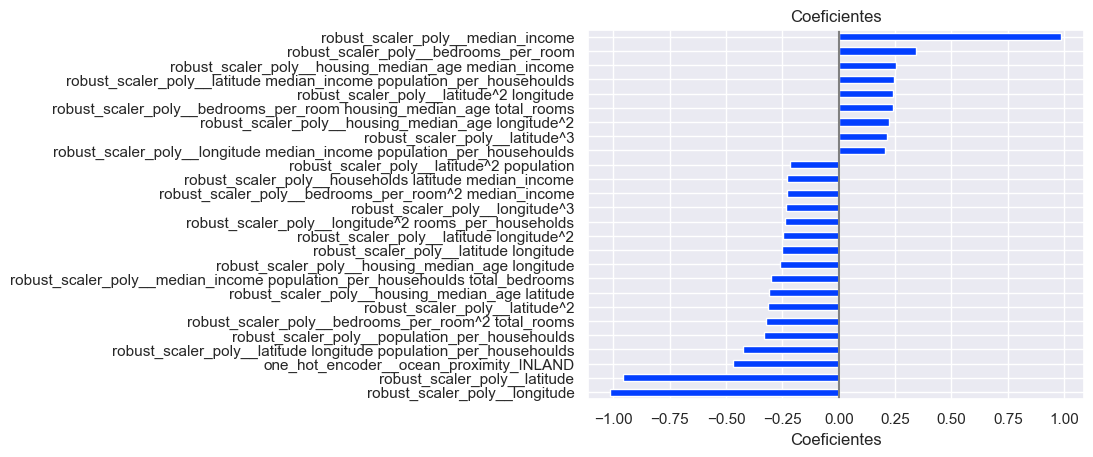

In [38]:
#Criando o gráfico dos coeficientes relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.2, 0.2)])

In [ ]:
#Comparando os modelos já treinados com meu gridsearch

regressors = {
    #Dummyregressor
    'DummyRegressor' : {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },

    #LinearRegressor sem transformação de target e só com categórcas
     'LinearRegression' : {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    
    #LinearRegressor com transformação de target quantile transformer (best param do grid search)
     'Ridge_grid_seach' : {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

In [ ]:
df_resultados.groupby('model').mean()

In [ ]:
plot_comparar_metricas_modelos(df_resultados)

In [ ]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True)